In [282]:
import pandas as pd
import numpy as np
import xgboost as xgb
import json

pd.set_option("display.width", None)

## Fix-up train & test sets
### Generate test set
```
python week2/utilities/build_ltr.py --generate_impressions --output_dir /workspace/ltr_output/test --train_file /workspace/ltr_output/test.csv --synthesize
python week2/utilities/build_ltr.py --ltr_terms_field sku --output_dir /workspace/ltr_output/test --create_xgb_training -f week2/conf/ltr_featureset.json --click_model heuristic --downsample
```
### Fix datasets 
Note: xgboost requires qids to be sorted. See: [docs](https://xgboost.readthedocs.io/en/stable/tutorials/input_format.html#embedding-additional-information-inside-libsvm-file)

> The rows have to be sorted in ascending order by the query IDs. So, for instance, you may not have one row having large query ID than any of the following rows.

```
sort -t: -k2,2n /workspace/ltr_output/training.xgb > /workspace/ltr_output/training_sorted.xgb
sort -t: -k2,2n /workspace/ltr_output/test/training.xgb > /workspace/ltr_output/test/training_sorted.xgb
```

## Fit model

In [112]:
dtrain = xgb.DMatrix('/workspace/ltr_output/training_sorted.xgb')
dtest = xgb.DMatrix('/workspace/ltr_output/test/training_sorted.xgb')

In [113]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [268]:
param = {
    'objective': 'rank:pairwise',
    'max_depth': 6,
    'eta': 0.05,
    'min_child_weight': 250,
    'subsample': 0.9,
    'colsample_bynode':0.9,
    'eval_metric': ['ndcg@10', 'map@10', 'ndcg', 'auc']
}

In [269]:
bst = xgb.train(param, dtrain, 50, evallist)

[0]	eval-ndcg@10:0.99456	eval-map@10:0.99264	eval-ndcg:0.99456	eval-auc:0.70509	train-ndcg@10:0.99499	train-map@10:0.99325	train-ndcg:0.99499	train-auc:0.72326
[1]	eval-ndcg@10:0.99634	eval-map@10:0.99504	eval-ndcg:0.99634	eval-auc:0.72150	train-ndcg@10:0.99772	train-map@10:0.99691	train-ndcg:0.99772	train-auc:0.74854
[2]	eval-ndcg@10:0.99777	eval-map@10:0.99698	eval-ndcg:0.99777	eval-auc:0.72470	train-ndcg@10:0.99839	train-map@10:0.99782	train-ndcg:0.99839	train-auc:0.75902
[3]	eval-ndcg@10:0.99984	eval-map@10:0.99979	eval-ndcg:0.99984	eval-auc:0.74971	train-ndcg@10:1.00000	train-map@10:1.00000	train-ndcg:1.00000	train-auc:0.76897
[4]	eval-ndcg@10:0.99984	eval-map@10:0.99979	eval-ndcg:0.99984	eval-auc:0.73948	train-ndcg@10:1.00000	train-map@10:1.00000	train-ndcg:1.00000	train-auc:0.76747
[5]	eval-ndcg@10:0.99984	eval-map@10:0.99979	eval-ndcg:0.99984	eval-auc:0.74128	train-ndcg@10:1.00000	train-map@10:1.00000	train-ndcg:1.00000	train-auc:0.76412
[6]	eval-ndcg@10:0.99984	eval-map@10:0.9

## Export Model
- Note: Need to handle negative values (ES can't handle). See LTR [repo](https://github.com/o19s/elasticsearch-learning-to-rank/blob/main/scripts/xgboost_model_fixr.py).

In [295]:
model = bst.get_dump(fmap='/workspace/ltr_output/xgb-feat-map.txt', dump_format='json')

In [296]:
model_str = '[' + ','.join(list(model)) + ']'

In [297]:
model_name = 'ltr_model'

In [299]:
model_payload = {
    "model": {
        "name": model_name,
        "model": {
            "type": "model/xgboost+json",
            "definition": ""
        }
    }
}
model_payload['model']['model']['definition'] = model_str

In [302]:
with open('/workspace/ltr_output/xgb-pairwise.json', 'w') as output:
    output.write(json.dumps(model_payload, indent=2))

### Run fixr
[xgboost_model_fixr.py](https://raw.githubusercontent.com/o19s/elasticsearch-learning-to-rank/main/scripts/xgboost_model_fixr.py)
```
python xgboost_model_fixr.py -i /workspace/ltr_output/xgb-pairwise.json -o /workspace/ltr_output/xgb_pairwise.model.ltr 
```

## Upload model
```
python week2/utilities/build_ltr.py --upload_ltr_model --xgb_model /workspace/ltr_output/xgb_pairwise.model
```

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

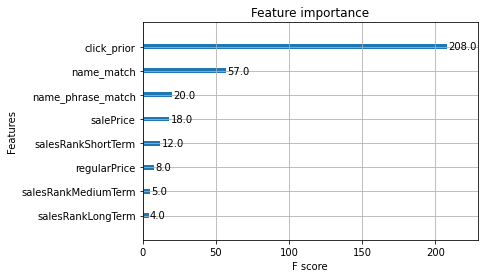

In [270]:
xgb.plot_importance(bst, fmap='/workspace/ltr_output/xgb-feat-map.txt')

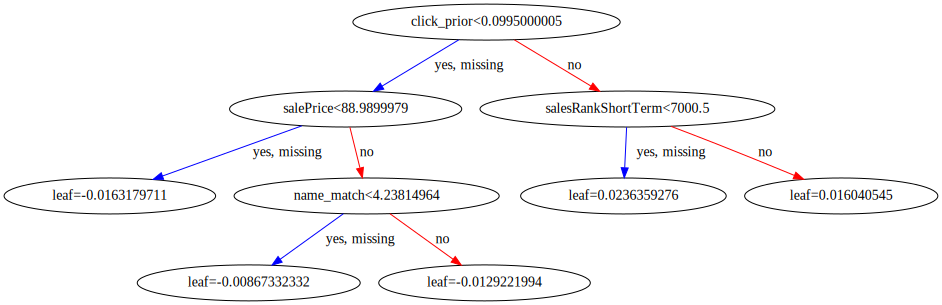

In [271]:
xgb.to_graphviz(bst, fmap='/workspace/ltr_output/xgb-feat-map.txt', num_trees=-1)

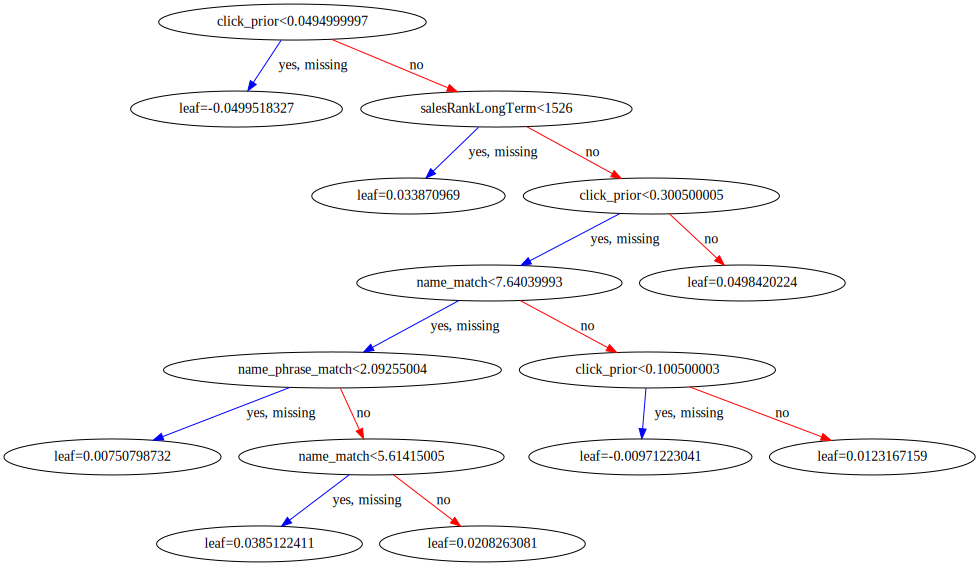

In [272]:
xgb.to_graphviz(bst, fmap='/workspace/ltr_output/xgb-feat-map.txt', num_trees=0)